In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

# Wstęp

W ramach tej pracy domowej zajmę się tematem wrażliwości sieci neurnonowych. Zgodnie z poleceniem przeanalizuje wpływ różnego rodzaju czynników na ich zachowanie oraz wyniki.

# Zjawisko niepewności

To jakie predykcje dostaniemy od sieci neuronowej w oczywisty sposób zależy od jej wag oraz tego jaki input ona dostanie. Manipulując choćby delikatnie przy którymś z tych aspektów możemy w znaczący sposób wpłynąć na to co otrzymamy w wyniku. Jeśli nasza sieć nauczyła się na danych "czystych" a jako dane testowe dostanie dane zaburzone (nawet w sposób niewidzialny dla ludzkiego oka), to może to znacząco wpłynąć na to jakie wyniki otrzymamy. W przypadku wpływania na wagi sieci, to róźnice mogą być jeszcze większe, gdyż w oczywisty sposób każda z następnych warstw korzysta z wyników warstw poprzednich, toteż nawet drobne przesunięcia moga skutkować katastrofalnymi różnicami na końcu. Stąd też zjawisko niepewności, może znacząco wpływać, albo nawet uniemożliwiać efektywną pracę z sieciami neuronowymi.

"Sensitivity analysis of deep neural networks." https://arxiv.org/pdf/1901.07152.pdf

"Uncertainty in Neural Networks:Approximately Bayesian Ensembling"
https://arxiv.org/pdf/1810.05546.pdf

## Model wejściowy

Jako mój model wejściowy zdecydowałem się wykorzystać popularnie stosowaną architekturę składającą się z wartst MaxPooling oraz Conv2D. Dane których będę używał to dane fashion mnist, z których korzystałem w poprzedniej pracy domowej.

In [123]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

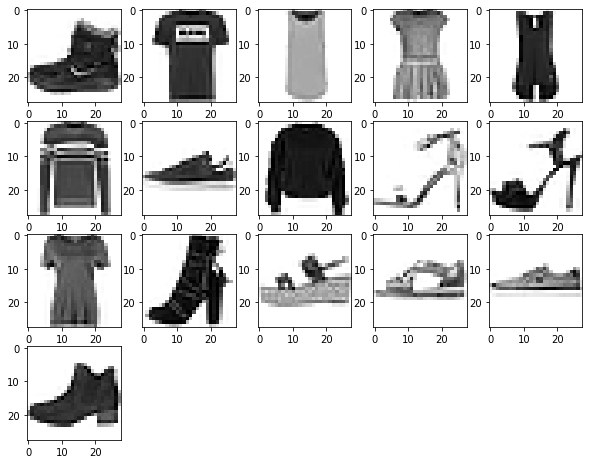

In [5]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [124]:
num_classes = 10
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [125]:
input_shape = (28,28,1)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

In [126]:
batch_size = 64
epochs = 10
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_1 = model.fit(x_train,y_train,batch_size=batch_size, epochs=epochs, validation_split=0.2)
wagi = np.array(model.get_weights())

Epoch 1/10
750/750 [==============================] - 32s 42ms/step - loss: 1.2058 - accuracy: 0.5655 - val_loss: 0.5767 - val_accuracy: 0.7862
Epoch 2/10
750/750 [==============================] - 32s 42ms/step - loss: 0.6164 - accuracy: 0.7792 - val_loss: 0.4970 - val_accuracy: 0.8177
Epoch 3/10
750/750 [==============================] - 32s 43ms/step - loss: 0.5474 - accuracy: 0.8001 - val_loss: 0.4571 - val_accuracy: 0.8308
Epoch 4/10
750/750 [==============================] - 32s 42ms/step - loss: 0.5086 - accuracy: 0.8165 - val_loss: 0.4449 - val_accuracy: 0.8365
Epoch 5/10
750/750 [==============================] - 32s 42ms/step - loss: 0.4779 - accuracy: 0.8246 - val_loss: 0.4178 - val_accuracy: 0.8484
Epoch 6/10
750/750 [==============================] - 32s 43ms/step - loss: 0.4593 - accuracy: 0.8318 - val_loss: 0.3944 - val_accuracy: 0.8538
Epoch 7/10
750/750 [==============================] - 33s 44ms/step - loss: 0.4404 - accuracy: 0.8416 - val_loss: 0.3976 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [128]:
np.save('wagi.npy', wagi) 

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score[1])

0.8654000163078308


# Dane wejściowe

W tej sekcji zmienię delikatnie dane wejściowe dodając do nich szum. Celem jest sprawdzenie zachowania sieci. Oczywiście szum dodam jedynie do danych testowych.

## Szum 

In [48]:
def gausian_noise(X):
  #mean= 0 #std=1
  shape = X.shape
  noise = np.random.randn(*shape) * 0.01
  data_out = X + noise
  return data_out

def poiss_noise(X:
  #lambda= 5
  shape = X.shape
  noise = np.random.poisson(5,size = shape) * 0.01
  data_out = X + noise
  return data_out

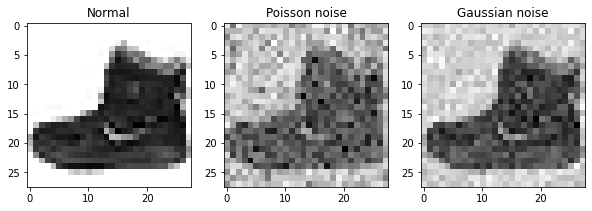

In [115]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,3,1)
ax.imshow(x_train[0].reshape(28,28), cmap=plt.cm.binary)
ax.title.set_text('Normal')
ax1 = plt.subplot(1,3,2)
ax1.imshow(poiss_noise(x_train[0]).reshape(28,28), cmap=plt.cm.binary)
ax1.title.set_text('Poisson noise')
ax2 = plt.subplot(1,3,3)
ax2.imshow(gausian_noise(x_train[0]).reshape(28,28), cmap=plt.cm.binary)
ax2.title.set_text('Gaussian noise')
plt.grid(False)


In [57]:
scores_gauss = []
scores_poiss = []
for i in range(10):
  x_test_gauss = np.empty(shape=x_test.shape)
  x_test_poiss = np.empty(shape=x_test.shape)
  for i in range(x_test.shape[0]):
    x_test_gauss[i] = gausian_noise(x_test[i])
    x_test_poiss[i] = poiss_noise(x_test[i])
  score_g = model.evaluate(x_test_gauss, y_test, verbose=0)
  scores_gauss.append(score_g[1])
  score_p = model.evaluate(x_test_poiss, y_test, verbose=0)
  scores_poiss.append(score_p[1])

In [58]:
print(f'Mean accuracy of Gaussian noise is {np.array(scores_gauss).mean()}, when std is {np.array(scores_gauss).std()}')
print(f'Mean accuracy of Poisson noise is {np.array(scores_poiss).mean()}, when std is {np.array(scores_poiss).std()}')

Mean accuracy of Gaussian noise is 0.7788199961185456, when std is 0.002023261524154004
Mean accuracy of Poisson noise is 0.20293999761343, when std is 0.002199182493649823


Jak widzimy dla różnego rodzaju szumu otrzymujemy różne wyniki. Na obrazkach widać było iż szum poissonowski dużo mocniej wpływał na wygląd obrazka, toteż nic dziwnego że wyniki z tym szumem są znacząco gorsze.

# Zmiana wagi jednej z warstw

Na samym początku zdecydowałem się dodać drobny szum do jednej z wag sieci. Arbitralnie wybrałem pierwszą warstwę, a w nastepnym podejściu wypróbuję dodać szum do każdej z wag.

In [141]:
scores = []
for i in range(10):
  w  = np.load('wagi.npy',allow_pickle=True)
  w[0] = gausian_noise(w[0])
  w[1] = gausian_noise(w[1])
  model.set_weights(w)
  score = model.evaluate(x_test, y_test, verbose=0)[1]
  scores.append(score)

In [142]:
print(f'Mean accuracy of Gaussian noise is {np.array(scores).mean()}, when std is {np.array(scores).std()}')

Mean accuracy of Gaussian noise is 0.7873800098896027, when std is 0.040968210727295826


In [143]:
scores = []
for i in range(10):
  w  = np.load('wagi.npy',allow_pickle=True)
  w[0] = poiss_noise(w[0])
  w[1] = poiss_noise(w[1])
  model.set_weights(w)
  score = model.evaluate(x_test, y_test, verbose=0)[1]
  scores.append(score)

In [144]:
print(f'Mean accuracy of Poisson noise is {np.array(scores).mean()}, when std is {np.array(scores).std()}')

Mean accuracy of Poisson noise is 0.24045000076293946, when std is 0.021544663365190134


Jak widzimy sieć zachowała pewną zdolność do predykcji, jednakże wynik są gorsze niż dla braku szumu. Sprawdźmy przesunięcie dla każdej z warstw z osobna. Sprawdzę to jedynie dla szumu gaussowskiego, jako że szum poissonowski osiąga dużo gorsze rezultaty, mocniej wpływając na wagi.

In [131]:
def change(nr= 0):
  scores = []
  for i in range(10):
    w  = np.load('wagi.npy',allow_pickle=True)
    w[nr] = gausian_noise(w[nr])
    w[nr +1] = gausian_noise(w[nr+1])
    model.set_weights(w)
    score = model.evaluate(x_test, y_test, verbose=0)[1]
    scores.append(score)
  return scores

scores_1 = change(0)
scores_2 = change(2)
scores_3 = change(4)
scores_4 = change(6)
sc = [scores_1,scores_2,scores_3,scores_4]

In [138]:
for i in range(4):
  print(f'Average acc when adding noise to layer number {i+1} is {np.array(sc[i]).mean()}, when std is {np.array(sc[i]).std()}')

Average acc when adding noise to layer number 1 is 0.7941299974918365, when std is 0.016197604417159207
Average acc when adding noise to layer number 2 is 0.847489994764328, when std is 0.004030741189130888
Average acc when adding noise to layer number 3 is 0.7934599995613099, when std is 0.01748527346012099
Average acc when adding noise to layer number 4 is 0.8315900087356567, when std is 0.013650225389945496


# Wszystkie warstwy

Na sam koniec zdecydowałem się sprawdzić zachowanie sieci po dodaniu do każdej z wag szumu.

In [132]:
scores = []
for i in range(10):
    w  = np.load('wagi.npy',allow_pickle=True)
    for j in range(w.shape[0]):
      w[j] = gausian_noise(w[j])
    model.set_weights(w)
    score = model.evaluate(x_test, y_test, verbose=0)[1]
    scores.append(score)
print(f'Average acc when adding gaussian noise to all layers is {np.array(scores).mean()}, when std is {np.array(scores).std()}')

Average acc when adding gaussian noise to all layers is 0.5883899956941605, when std is 0.09538443694557114


In [133]:
scores = []
for i in range(10):
    w  = np.load('wagi.npy',allow_pickle=True)
    for j in range(w.shape[0]):
      w[j] = poiss_noise(w[j])
    model.set_weights(w)
    score = model.evaluate(x_test, y_test, verbose=0)[1]
    scores.append(score)

print(f'Average acc when adding poisson noise to all layers is {np.array(scores).mean()}, when std is {np.array(scores).std()}')

Average acc when adding poisson noise to all layers is 0.10000000149011612, when std is 0.0


Jak pokazały moje eksperymenty nawet najmniejsze zaburzenie wag modelu może doprowadzić do znacznego pogorszenia wyniku. Równie duże zmiany mogą być widoczne w przypadku dodania szumu dodanych wejsćiowych. Jednakże nie każda manipulacja musi całkowicie zmienić wynik, co udało mi się pokazać poprzez zmiany wag pojedyńczych warstw, gdzie dodanie szumu nie wpłynęło znacząco na wynik.